In [1]:
import xarray as xr 
import cartopy.crs as ccrs
import matplotlib.path as mpath
import cartopy.feature as cfeature
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import colorsys

#plot parameters that I personally like, feel free to make these your own.
import matplotlib
import matplotlib.patheffects as path_effects

#outlines for text 
pe1 = [path_effects.withStroke(linewidth=1.5,
                             foreground="k")]
pe2 = [path_effects.withStroke(linewidth=1.5,
                             foreground="w")]

# matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9] #makes a grey background to the axis face
matplotlib.rcParams['axes.labelsize'] = 14 #fontsize in pts
matplotlib.rcParams['axes.titlesize'] = 14 
matplotlib.rcParams['xtick.labelsize'] = 12 
matplotlib.rcParams['ytick.labelsize'] = 12 
matplotlib.rcParams['legend.fontsize'] = 12 
matplotlib.rcParams['legend.facecolor'] = 'w' 
matplotlib.rcParams['savefig.transparent'] = False


colors = ['#F6A5AE', '#228833', '#4577AA','#67CCED', '#AA3377']

from scipy import stats
from decimal import Decimal


### Make violin plots for review figure

In [4]:
# Choose a region and open the netcdf files of testing data correctly identified Top Snow day SHAP values calculated in Calculate_regional_shap
r=4
folder = '/pl/active/ATOC_SynopticMet/data/ar_data/Research3/CNN_retry/CNN_retry_2V/shap/'
shap_ds = xr.open_mfdataset(folder+'TP_shap_'+str(r)+'*')
shap_ds = xr.DataArray(
    data = shap_ds.__xarray_dataarray_variable__.values,
    dims = ['regions', 'time', 'lat', 'lon', 'n_channel'],
    coords= {'regions': shap_ds.regions, 'time':shap_ds.time, 
             'lat':shap_ds.lat, 'lon':shap_ds.lon, 'n_channel':shap_ds.n_channel}
)
# select the SHAP values for the region you are interested in
shap_ds_region = shap_ds.isel(regions = r)

In [5]:
#sum SHAP values over space to get a singular SHAP value for each Top Snow day
shap_ds_region_spatialsum = shap_ds_region.sum(dim = ('lat', 'lon'))

In [12]:
# Calculate the difference in means of the SHAP values for V and IWV
stat = str(np.round(stats.ttest_ind(shap_ds_region_spatialsum.sel(n_channel = 'V'), shap_ds_region_spatialsum.sel(n_channel = 'IWV'), equal_var = False)[0],2))
p_value = f"{Decimal(stats.ttest_ind(shap_ds_region_spatialsum.sel(n_channel = 'V'), shap_ds_region_spatialsum.sel(n_channel = 'IWV'), equal_var = False)[1]):.1E}"
print('T-Statistic Difference of Means: '+stat+', P-value: '+p_value)

T-Statistic Difference of Means: 4.06, P-value: 5.7E-5


In [22]:
titles = shap_ds_region.n_channel.values
def custom_violin(ax, data, pos, fc='b', ec='k', alpha=0.6, percentiles=[50], side="both", scatter_kwargs={}, violin_kwargs={}):
    """Customized violin plot.
    ax: axes.Axes, The axes to plot to
    data: 1D array like, The data to plot
    pos: float, The position on the x-axis where the violin should be plotted
    fc: color, The facecolor of the violin
    ec: color, The edgecolor of the violin
    alpha: float, The transparancy of the violin
    percentiles: array like, The percentiles to be marked on the violin
    side: string, Which side(s) of the violin should be cut off. Options: 'left', 'right', 'both'
    scatter_kwargs: dict, Keyword arguments for the scatterplot
    violin_kwargs: dict, Keyword arguments for the violinplot"""

    parts = ax.violinplot(data, positions=[pos], vert= False, **violin_kwargs)
    for pc in parts['bodies']:
        m = np.mean(pc.get_paths()[0].vertices[:, 0])
        if side == "left":
            points_x = pos - 0.05
            pc.get_paths()[0].vertices[:, 0] = np.clip(pc.get_paths()[0].vertices[:, 0], -np.inf, m)
        elif side == "right":
            points_x = pos + 0.05
            pc.get_paths()[0].vertices[:, 0] = np.clip(pc.get_paths()[0].vertices[:, 0], m, np.inf)
        else:
            points_x = pos
        pc.set_facecolor(fc)
        pc.set_edgecolor(ec)
        pc.set_alpha(alpha)

    perc = np.percentile(data, percentiles)
    for p in perc:
        ax.scatter( p, points_x, color=ec, zorder=3, **scatter_kwargs)

Text(0.5, 1.0, 'T-Statistic Difference of Means: 4.06, P-value: 5.7E-5')

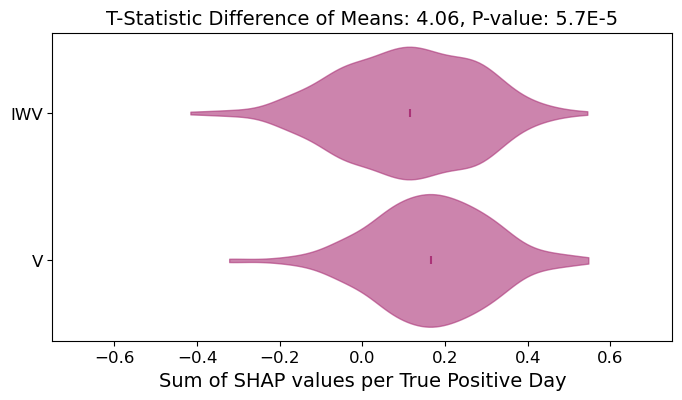

In [28]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (8,4))
s_kwargs = {"s": 40, "marker": "|"}
v_kwargs = {"showextrema": False, "showmedians": False, "showmeans": False, "widths": .9}

custom_violin(axes, shap_ds_region_spatialsum.sel(n_channel = 'V'), 0, colors[r], colors[r], scatter_kwargs=s_kwargs, violin_kwargs=v_kwargs)
custom_violin(axes, shap_ds_region_spatialsum.sel(n_channel = 'IWV'), 1, colors[r], colors[r], scatter_kwargs=s_kwargs, violin_kwargs=v_kwargs)
# custom_violin(axes, violin_df[2], 2, colors[r], colors[r], scatter_kwargs=s_kwargs, violin_kwargs=v_kwargs)

axes.set_yticks([0,1])
axes.set_yticklabels(titles)
axes.set_xlabel('Sum of SHAP values per True Positive Day')
axes.set_xlim([-.75,.75])
plt.title('T-Statistic Difference of Means: '+stat+', P-value: '+p_value)
# plt.savefig('/projects/reba1583/Research3/AntarcticAR_ML/NeuralAdditiveModel/tests/precip/CNN_retry_2V/Figures/review_shap_region'+str(r)+'.png', dpi = 300, transparent = True, bbox_inches = 'tight')
